In [1]:
import trueskillthroughtime as ttt
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("dark_background") 

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:


df = pd.read_csv('games.csv')

df['handicap'].mean()
df.head()

,id,created,modified,handicap,komi,result,reason,points,date,black_player_id,...,event_id,description,unrated,id.1,created.1,modified.1,name,start_date,end_date,description.1
0,6791,2023-07-05 02:57:16,2023-07-05 02:57:16,0,6.5,black,unknown,0.0,2023-01-15,142,...,122,NaN,0,122,2023-07-05 02:57:16,2023-07-05 02:57:16,Clasificatorio Equipo Argentino 7.ª Liga Panda...,2023-01-14,2023-01-15,NaN
1,6790,2023-07-05 02:57:16,2023-07-05 02:57:16,0,6.5,black,unknown,0.0,2023-01-15,173,...,122,NaN,0,122,2023-07-05 02:57:16,2023-07-05 02:57:16,Clasificatorio Equipo Argentino 7.ª Liga Panda...,2023-01-14,2023-01-15,NaN
2,6789,2023-07-05 02:57:16,2023-07-05 02:57:16,0,6.5,black,unknown,0.0,2023-01-15,208,...,122,NaN,0,122,2023-07-05 02:57:16,2023-07-05 02:57:16,Clasificatorio Equipo Argentino 7.ª Liga Panda...,2023-01-14,2023-01-15,NaN
3,6788,2023-07-05 02:57:16,2023-07-05 02:57:16,0,6.5,white,unknown,0.0,2023-01-15,45,...,122,NaN,0,122,2023-07-05 02:57:16,2023-07-05 02:57:16,Clasificatorio Equipo Argentino 7.ª Liga Panda...,2023-01-14,2023-01-15,NaN
4,6787,2023-07-05 02:57:16,2023-07-05 02:57:16,0,6.5,white,unknown,0.0,2023-01-14,142,...,122,NaN,0,122,2023-07-05 02:57:16,2023-07-05 02:57:16,Clasificatorio Equipo Argentino 7.ª Liga Panda...,2023-01-14,2023-01-15,NaN


In [3]:

df['winner_id'] = df.apply(lambda row : str(row['black_player_id']) if row['result'] == 'black' else str(row['white_player_id']), axis = 1)
df['looser_id'] = df.apply(lambda row : str(row['white_player_id']) if row['result'] == 'black' else str(row['black_player_id']), axis = 1)
df['winner_handicap'] =  df.apply(lambda row : 'handi_' + str(row['handicap']) if row['result'] == 'black' else 'handi_0', axis = 1)
df['looser_handicap'] = df.apply(lambda row : 'handi_0' if row['result'] == 'black' else 'handi_' + str(row['handicap']), axis = 1)


def winner_team(row):
    if row['result'] == 'black':
        return [str(row['black_player_id']) , 'handi_1', 'handi_0']
    else:
        return [str(row['white_player_id']) ]
        
def looser_team(row):
    if row['result'] == 'white':
        return [str(row['black_player_id']) , 'handi_1', 'handi_0']
    else:
        return [str(row['white_player_id']) ] 

def winner_team_weights(row):
    handicap = float(row.handicap)
    dividend = (2.0+handicap)
    if row['result'] == 'black':
        return [1.0/dividend, handicap, 1.0/dividend]
    else:
        return [1.0]
    
        
def looser_team_weights(row):
    handicap = float(row.handicap)
    dividend = (2.0+handicap)
    if row['result'] == 'white':
        return [1.0/dividend, handicap/dividend, 1.0/dividend]
    else:
        return [1.0] 


df['winner_team'] = df.apply(winner_team, axis = 1)
df['looser_team'] = df.apply(looser_team, axis = 1)
df['winner_team_weights'] = df.apply(winner_team_weights, axis = 1)
df['looser_team_weights'] = df.apply(looser_team_weights, axis = 1)


players_ids = set(df['winner_id']).union(set(df['looser_id']))
handi_ids= set(['handi_0'] +[ 'handi_' + str(i) for i in range(2,10)] )

# handi_ids
# df['start_date']
df[['handicap', 'result', 'winner_handicap', 'winner_team']]
# df.dtypes


,handicap,result,winner_handicap,winner_team
0,0,black,handi_0,"[142, handi_1, handi_0]"
1,0,black,handi_0,"[173, handi_1, handi_0]"
2,0,black,handi_0,"[208, handi_1, handi_0]"
3,0,white,handi_0,[7]
4,0,white,handi_0,[96]
...,...,...,...,...
6486,0,white,handi_0,[3]
6487,0,black,handi_0,"[4, handi_1, handi_0]"
6488,0,white,handi_0,[4]
6489,0,white,handi_0,[1]


In [15]:
columns = zip(df.winner_team, df.looser_team)
composition = [ [w,l] for w, l in columns ]

weights = [ [ww, lw] for ww, lw in zip(df.winner_team_weights, df.looser_team_weights)]
times = [ datetime.strptime(t, "%Y-%m-%d").timestamp()/(60*60*24) for t in df.end_date]

EPSILON = 0.01
ITERATIONS = 16 # 16
BETA = 2  # relation between performance and winning probability (spread)
MU = 0
SIGMA = 1.25 * BETA # standard deviations of priors
GAMMA = 0.025 * BETA # time uncertainty
HANDI_SIGMA = 1 * SIGMA
HANDI1_MU = MU


priors_handi = {'handi_1': ttt.Player(ttt.Gaussian(HANDI1_MU, HANDI_SIGMA), beta=0,gamma=0),
                'handi_0': ttt.Player(ttt.Gaussian(MU, HANDI_SIGMA), beta=0,gamma=0)
               }

h = ttt.History(composition = composition, times = times, priors= priors_handi, mu=MU, sigma=SIGMA, gamma=GAMMA, weights= weights)
h.convergence(epsilon=EPSILON, iterations=ITERATIONS) # 16



Iteration =  0 , step =  (4.638589054166785, 2.441996909524817)
Iteration =  1 , step =  (0.6159029283812094, 0.12034438387455149)
Iteration =  2 , step =  (0.4460507727995795, 0.048612489087816124)
Iteration =  3 , step =  (0.37521985344592235, 0.03728071928928589)
Iteration =  4 , step =  (0.31672713209284176, 0.03162313031504338)
Iteration =  5 , step =  (0.2670746615119066, 0.026939053247988287)
Iteration =  6 , step =  (0.22673994232423933, 0.023010043180522688)
Iteration =  7 , step =  (0.19362436192364996, 0.01969560971010731)
Iteration =  8 , step =  (0.16563870709783401, 0.016890135672801954)
Iteration =  9 , step =  (0.14194422845259247, 0.014509147584910398)
Iteration =  10 , step =  (0.12184458299331347, 0.012483549593392596)
Iteration =  11 , step =  (0.10475930883277584, 0.010756365904445397)
Iteration =  12 , step =  (0.09028216257806054, 0.00928044366201175)
Iteration =  13 , step =  (0.0781832014786703, 0.008016658341328364)
Iteration =  14 , step =  (0.067763212236213

((0.05877578196340316, 0.006010991089648199), 16)

In [17]:
import math

print(h.log_evidence())
math.exp(h.log_evidence()/h.size)

-2178.9171196937355


0.7148498130735188

In [18]:

# agents = df.winner_id.sample(n=5).to_list() #+ 

agents = [ 'handi_' + str(i) for i in range(0,2)]

# agents = handi_ids



handi_0 15517.125 3.757549426477324 0.05917997201275391
handi_1 15517.125 1.7177178419956023 0.04320440901530529


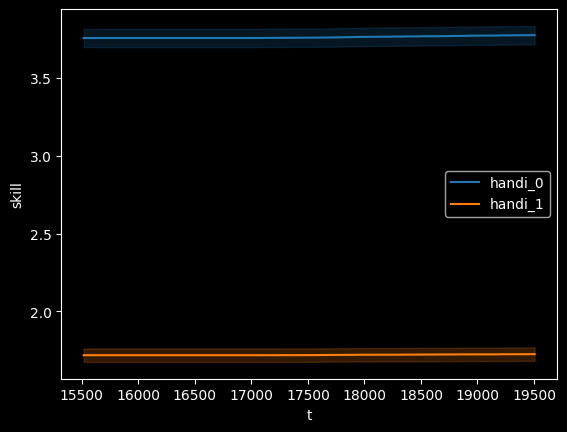

In [19]:


lc = h.learning_curves()
pp = plt.figure(); plt.xlabel("t"); plt.ylabel("skill")
cmap = plt.get_cmap("tab10")
for i, agent in enumerate(agents):
    t = [v[0] for v in lc[agent]]
    mu = [v[1].mu for v in lc[agent]]
    sigma = [v[1].sigma for v in lc[agent]]
    print(agent, t[0], mu[0], sigma[0])
    plt.plot(t, mu, color= cmap(i), label=agent)
    plt.fill_between(t, [m+s for m,s in zip(mu, sigma)], [m-s for m,s in zip(mu, sigma)], alpha=0.2, color = cmap(i))

plt.legend()
plt.show()




<Axes: ylabel='new_mu'>

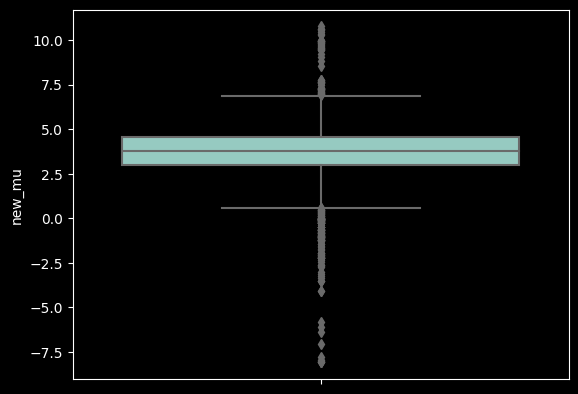

In [20]:
learning_curves = h.learning_curves()

l = []

for entry in learning_curves.items():
    for tup in entry[1]:
        l.append([entry[0], tup[0], tup[1].mu ])


new_ratings = pd.DataFrame(l, columns=['player_id', 'time', 'new_mu'])


new_ratings = new_ratings[~ new_ratings['player_id'].isin(['handi_0', 'handi_1' ])]
new_ratings['player_id'] = pd.to_numeric(new_ratings['player_id'])


sns.boxplot(data=new_ratings, y='new_mu')

# Ajuste de Curva con ratings actuales

In [25]:
current_ratings = pd.read_csv('ratings.csv')

def converted_mu(x):
    return x + (x<0) - (x>0)

current_ratings[['player_id', 'mu', 'end_date']]
current_ratings['time'] = current_ratings['end_date'].apply(lambda series: datetime.strptime(series, "%Y-%m-%d").timestamp()/(60*60*24) ) 

# Por algun motivo, skippea valores entre -1 y uno
current_ratings['mu'] = current_ratings['mu'].apply(converted_mu)



small_old_ratings = current_ratings[['player_id', 'mu', 'time']]
small_old_ratings.rename(columns={ 'mu': 'mu_old'}, inplace=True)

# df_plot = small_old_ratings[small_old_ratings.player_id.isin(small_old_ratings.player_id.sample(5))]

# sns.lineplot(x='time', y ='mu_old', hue='player_id', data=df_plot)
# df_plot.dtypes

/tmp/ipykernel_169829/4279370949.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_old_ratings.rename(columns={ 'mu': 'mu_old'}, inplace=True)


In [26]:
merged_ratings = small_old_ratings.merge(new_ratings, how = 'inner')

merged_ratings = merged_ratings[merged_ratings['time']> 16500]
merged_ratings = merged_ratings[merged_ratings['mu_old']> -10]
merged_ratings = merged_ratings[merged_ratings['mu_old'] < 9]

merged_ratings

df_plot = merged_ratings[merged_ratings.player_id.isin(merged_ratings.player_id.sample(5))]

# sns.scatterplot(x='new_mu', y ='mu_old', hue='time', data=df_plot)

(-11.546714797551575, 2.0212317656109673, 0.5486541439925361)

<Axes: ylabel='predict'>

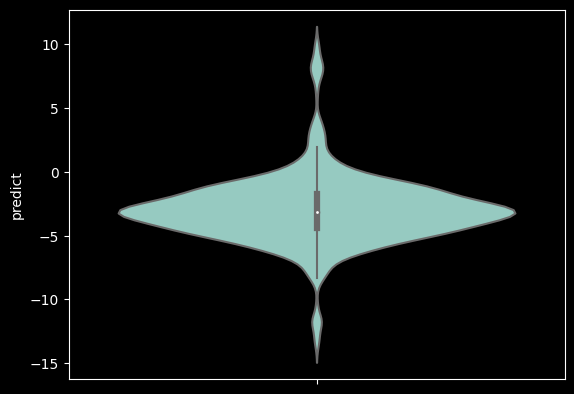

In [32]:
## Linear Regression

from sklearn.linear_model import LinearRegression

model = LinearRegression()

x = merged_ratings['new_mu'].to_numpy().reshape((-1,1))
y = merged_ratings['mu_old'].to_numpy()


model.fit(x,y)

display((model.intercept_, model.coef_[0], model.score(x,y)))




merged_ratings['predict'] = model.predict(x)

sns.violinplot(y='predict', data=merged_ratings)


In [33]:
z = (merged_ratings['mu_old'] - merged_ratings['new_mu'] ).median()


z

-6.833771523512635

<Axes: ylabel='new_mu'>

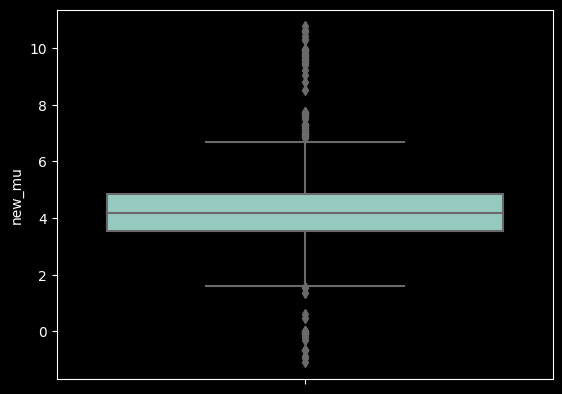

In [29]:
merged_ratings['new_mu'].max()



sns.boxplot(y='new_mu' ,data=merged_ratings)